# 15. 과적합

과적합은 학습 데이터에 치중하여 모델이 학습하는 현상으로 새로운 데이터에 대해서 대응을 못하는 문제다. 따라서 딥러닝에서 가장 쉽게 접할 수 있는 문제 유형이며 개선하지 힘든 문제다.  

## 15.1 Dropout & Batch Normalization


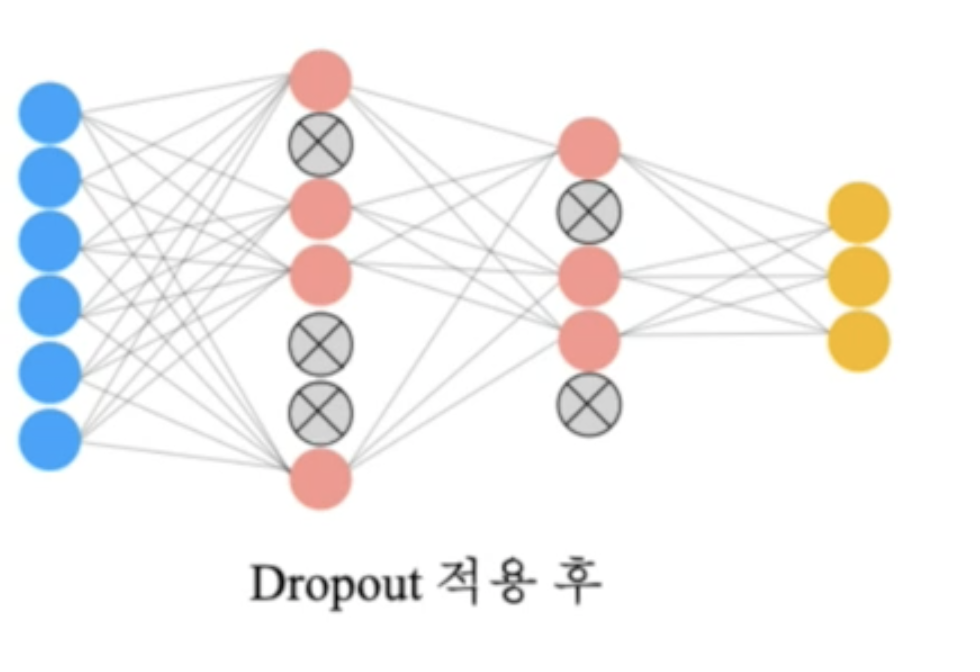

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.feature_extraction = nn.Sequential(nn.Conv2d(3, 6, 5), 
                                                nn.BatchNorm2d(6), #배치놈 : 주로 CNN 연산이 끝나고 난 후에 넣는다. 각 채널의 평균과 표준편차를 계산해서 정규화 한다.
                                                nn.ReLU(),
                                                nn.MaxPool2d(2, 2), 
                                                nn.Conv2d(6, 16, 5),
                                                nn.BatchNorm2d(16), # 아웃풋의 채널수와 동일한 채널 수를 입력해주면된다. 정규화 이후에는 항상 균일한 데이터가 넘어가서, 수렴속도와 과적합이 개선된다.
                                                nn.ReLU(),
                                                nn.MaxPool2d(2, 2))
        # 드랍아웃은 일반적으로 CNN의 피쳐추출 부분에서는 사용하지 않고, 분류기에서 사용한다.
        # 분류기의 레이어가 깊을 수록 과적합이 발생할 확률이 높아진다.
        # CNN에서는 얼마나 피쳐를 잘 추출하느냐가 관건이기 때문에 분류기의 레이어는 깊게 구성하지 않아도 괜찮다.
        self.classifier = nn.Sequential(nn.Linear(512, 120),
                                        nn.ReLU(),
                                        nn.Dropout(0.5), # 비활성화 시킬 노드의 비율/ 랜덤으로 50% 노드 비활성화
                                        nn.Linear(120, 64),
                                        nn.ReLU(),
                                        nn.Linear(64, 10))
                                        
    def forward(self, x):
        x = self.feature_extraction(x)
        x = x.view(-1, 512) 
        x = self.classifier(x)

        return x

net = CNN().to(device) # 모델 선언

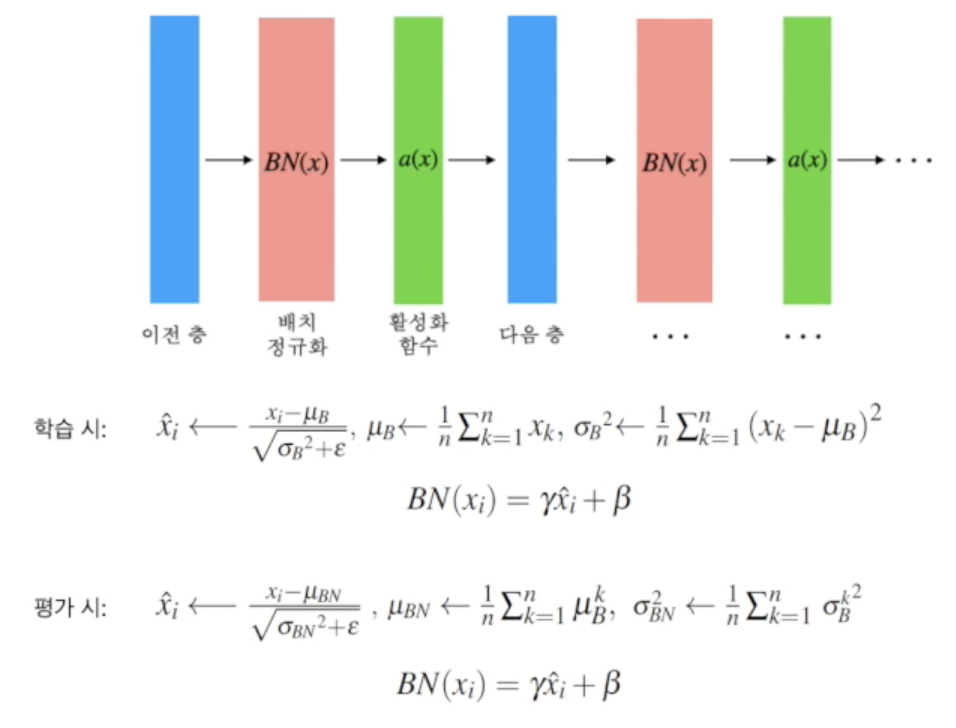

##15.2 L2 Regularization

In [ ]:
import torch.optim as optim

# 가중치가 업데이트 되는 바로 앞에서 패널티가 적용된다.
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2) # 모델 최적화에서 패널티를 걸어준다. 너무 큰 값을 해버리면 학습이 잘 안됨

## 15.3 Data Augmentation

In [ ]:
# https://pytorch.org/docs/stable/torchvision/transforms.html에서 다양한 전처리 방법들을 확인할 수 있다.
import torchvision.transforms as tr
import PIL

transf = tr.Compose(
                [tr.ToPILImage(), tr.RandomCrop(60), tr.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                 tr.RandomHorizontalFlip(),
                 tr.RandomRotation(10, resample=PIL.Image.BILINEAR),
                 tr.ToTensor()
                 ])

## 15.4 Label Smoothing

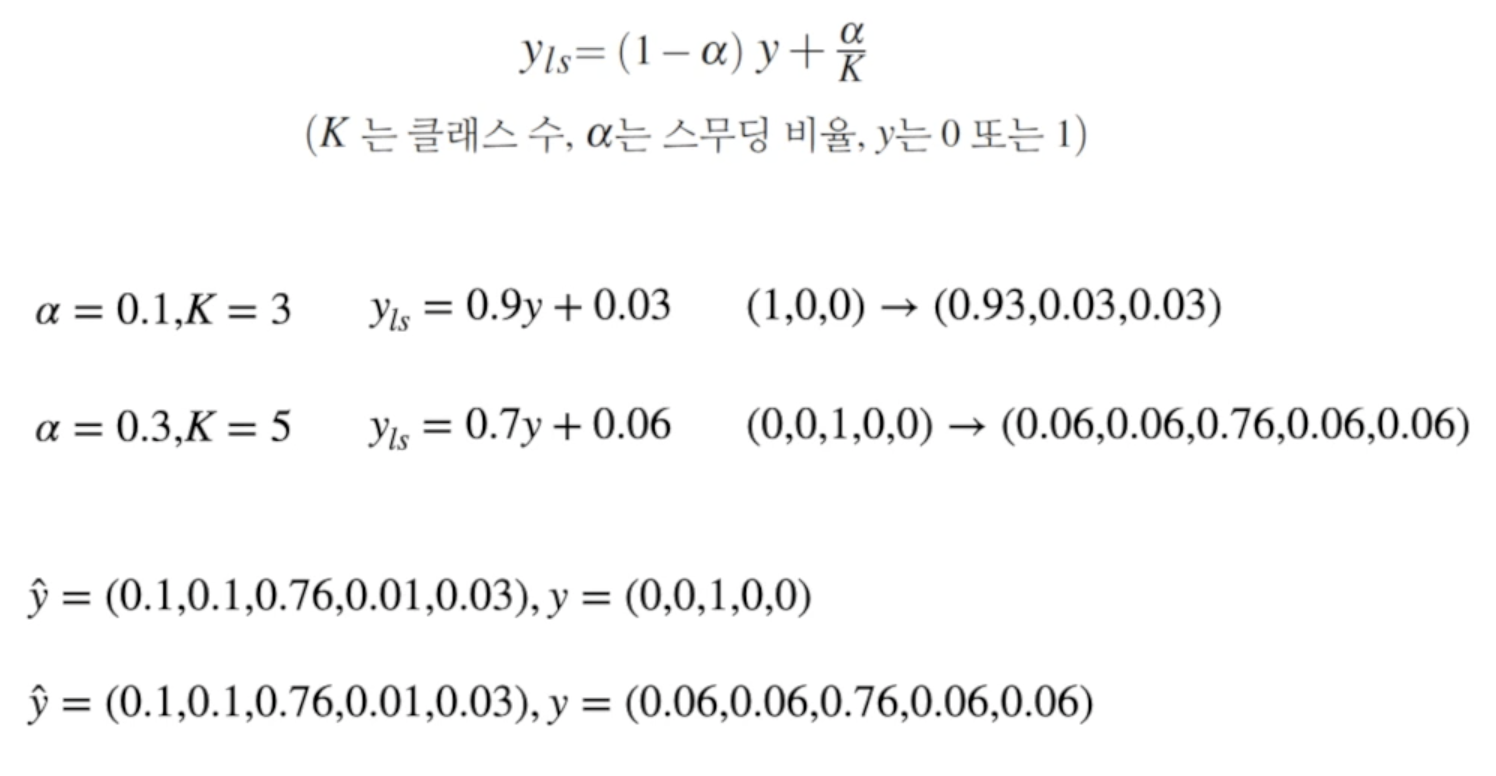

In [ ]:
# 각각의 클래스의 격차를 줄여주는 방법
# 원핫 인코딩 방식으로 딱딱 0아니면 1 이렇게 나누는게 아닌
# 정답이면 0.8, 정답이 아니면 0.2 이런식으로 격차를 줄여준다.
import torch.nn as nn

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim) # Cross Entropy 부분의 log softmax 미리 계산하기
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred) # 예측값과 동일한 크기의 영텐서 만들기
            true_dist.fill_(self.smoothing / (self.cls - 1)) # alpha/(K-1)을 만들어 줌(alpha/K로 할 수도 있음)
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # (1-alpha)y + alpha/(K-1)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim)) # Cross Entropy Loss 계산

In [ ]:
ls = LabelSmoothingLoss(10, smoothing=0.2)

In [ ]:
# 실제 사용 방법
for data in trainloader:
  ..... # 나머지는 동일하게 적음
  
  # loss- loss(pred, labels) # 원래 방식
  loss = ls(pred, labels) # 로스 부분만 수정

  .....
